In [109]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print(os.listdir("../input/intel-image-classification"))
data_dir = "../input/intel-image-classification"
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['seg_train', 'seg_pred', 'seg_test']


In [110]:
!ls ../input/intel-image-classification

seg_pred  seg_test  seg_train


In [111]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [112]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.002
epoch=20
# Other constants
input_size = 128*128
num_classes = 10

In [113]:
train_dir = data_dir + '/seg_train/seg_train'
test_dir = data_dir+ '/seg_test/seg_test'

#classes in dataset:
classes = os.listdir(train_dir)
classes

['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']

In [115]:
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_tfms = transforms.Compose([transforms.Resize((150,150)),
                         transforms.ToTensor(),
                         transforms.Normalize(*stats,inplace=True)])

# train_tfms = transforms.Compose([transforms.Resize((150,150)),
#                          transforms.ToTensor(),
#                          transforms.Normalize(*stats,inplace=True),
#                          transforms.ToPILImage(),
#                          transforms.RandomCrop(100, padding=4, padding_mode='reflect'),
#                          transforms.Resize((150,150)),
#                          transforms.RandomHorizontalFlip(), 
#                          transforms.ToTensor()])


test_tfms = transforms.Compose([transforms.Resize((150,150)),transforms.ToTensor(), 
                         transforms.Normalize(*stats)])

ds = ImageFolder(train_dir, train_tfms)
test_ds = ImageFolder(test_dir, test_tfms)
ds_show = ImageFolder(train_dir,transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor()]))

ds

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: ../input/intel-image-classification/seg_train/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [116]:
ds

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: ../input/intel-image-classification/seg_train/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

torch.Size([3, 150, 150]) 3
Label:  mountain (3)


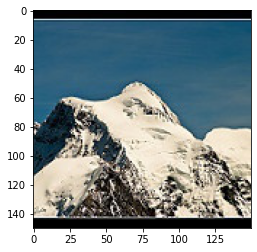

Label:  mountain (3)


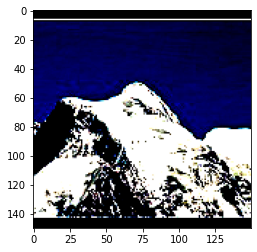

In [117]:
matplotlib.rcParams['figure.facecolor'] = '#ffffff'
def show_example(img, label):
    print('Label: ', ds_show.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

img, label = ds_show[8555]
print(img.shape, label)

show_example(*ds_show[8555])
plt.show()
show_example(*ds[8555])
plt.show()

In [118]:
random_seed=2021;
torch.manual_seed(random_seed);
val_size=4000
train_size=len(ds)-val_size
train_ds,val_ds=random_split(ds,[train_size,val_size])

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size*2)

val_dl

In [119]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.expansion = 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [120]:
class ResNet(nn.Module):
    def __init__(self, block, image_channels, num_classes):
    
        super(ResNet, self).__init__()
        self.expansion = 1
  
        layers = [3, 4, 6, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, block, num_residual_blocks, intermediate_channels, stride):
        layers = []
        
        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels)) 
        return nn.Sequential(*layers)

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
    
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)) 

In [121]:
def ResNet34(img_channels=3, num_classes=1000):
    return ResNet(Block, img_channels, num_classes)

model = ResNet34(num_classes=6)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [122]:
# class ImageModel(nn.Module):
#     def __init__(self):   
#         super().__init__()
#         self.network = nn.Sequential(
#             nn.Conv2d(3,16,(3,3)),
#             nn.ReLU(),
#             nn.Conv2d(16, 16, (3,3)), 
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.MaxPool2d(3, 3), 

#             nn.Conv2d(16, 32, (3,3)), 
#             nn.ReLU(),
#             nn.Conv2d(32, 32, (3,3)),  
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.MaxPool2d(2, 2), 

#             nn.Conv2d(32, 64, (3,3)), 
#             nn.ReLU(),
#             nn.Conv2d(64, 64, (3,3)), 
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.MaxPool2d(2, 2), 
            
#             nn.Conv2d(64, 128, (3,3)), 
#             nn.ReLU(),
#             nn.Conv2d(128, 128, (3,3)), 
#             nn.ReLU(),
#             nn.BatchNorm2d(128),
            
#             nn.Conv2d(128, 256, (3,3), padding='same'), 
#             nn.ReLU(),
#             nn.Conv2d(256, 256, (3,3), padding='same'),
#             nn.ReLU(),
#             nn.BatchNorm2d(256),
#             nn.MaxPool2d(2, 2),
#             nn.Dropout(0.4),
            
#             nn.Flatten(),
            
#             nn.Linear(1024,256),
#             nn.ReLU(),
#             nn.BatchNorm1d(256),
#             nn.Dropout(0.25),
            
#             nn.Linear(256,128),
#             nn.ReLU(),
#             nn.BatchNorm1d(128),
#             nn.Dropout(0.25),
            
#             nn.Linear(128,64),
#             nn.ReLU(),
#             nn.BatchNorm1d(64),
#             nn.Dropout(0.25),
            
#             nn.Linear(64,32),
#             nn.ReLU(),
#             nn.BatchNorm1d(32),
#             nn.Dropout(0.25),
            
#             nn.Linear(32,16),
#             nn.ReLU(),
#             nn.BatchNorm1d(16),
#             nn.Dropout(0.4),
            
#             nn.Linear(16, 6))
        
#     def forward(self, xb):
#         return self.network(xb)

#     def training_step(self, batch):
#         images, labels = batch 
#         out = self(images)                  # Generate predictions
#         loss = F.cross_entropy(out, labels) # Calculate loss
#         return loss
    
#     def validation_step(self, batch):
#         images, labels = batch 
#         out = self(images)                    # Generate predictions
#         loss = F.cross_entropy(out, labels)   # Calculate loss
#         acc = accuracy(out, labels)           # Calculate accuracy
#         return {'val_loss': loss.detach(), 'val_acc': acc}
        
#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_accs = [x['val_acc'] for x in outputs]
#         epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
#         return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
#     def epoch_end(self, epoch, result):
#         print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
#             epoch, result['train_loss'], result['val_loss'], result['val_acc']))
    
# def accuracy(outputs, labels):
#     _, preds = torch.max(outputs, dim=1)
#     return torch.tensor(torch.sum(preds == labels).item() / len(preds))    
   

# model = ImageModel()
# print(model)

In [123]:
device = torch.device('cuda')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

In [124]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [125]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, optimizer):
    history = []
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [126]:
model = to_device(model, device)

optimizer = torch.optim.Adam(model.parameters(),learning_rate)

reduce = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [127]:
evaluate(model, val_dl)

{'val_loss': 1.7893810272216797, 'val_acc': 0.1865234375}

In [129]:
history = fit(epoch, learning_rate, model, train_dl, val_dl, optimizer)

Epoch [0], train_loss: 1.0584, val_loss: 0.8601, val_acc: 0.6677
Epoch [1], train_loss: 0.7231, val_loss: 0.7319, val_acc: 0.7384
Epoch [2], train_loss: 0.6269, val_loss: 0.8163, val_acc: 0.6858
Epoch [3], train_loss: 0.5384, val_loss: 0.7391, val_acc: 0.7363
Epoch [4], train_loss: 0.5068, val_loss: 0.4966, val_acc: 0.8264
Epoch [5], train_loss: 0.4598, val_loss: 0.5858, val_acc: 0.7913
Epoch [6], train_loss: 0.4216, val_loss: 1.5856, val_acc: 0.5969
Epoch [7], train_loss: 0.4094, val_loss: 0.5248, val_acc: 0.8076
Epoch [8], train_loss: 0.3825, val_loss: 0.5348, val_acc: 0.8037
Epoch [9], train_loss: 0.3598, val_loss: 0.5907, val_acc: 0.7904
Epoch [10], train_loss: 0.3298, val_loss: 0.4060, val_acc: 0.8531
Epoch [11], train_loss: 0.3249, val_loss: 0.5371, val_acc: 0.8204
Epoch [12], train_loss: 0.2910, val_loss: 0.8164, val_acc: 0.7141
Epoch [13], train_loss: 0.2964, val_loss: 0.5406, val_acc: 0.8160
Epoch [14], train_loss: 0.2633, val_loss: 0.5031, val_acc: 0.8483
Epoch [15], train_lo

In [132]:
history2 = fit(5, learning_rate, model, train_dl, val_dl, optimizer) #дообучаем сеть

Epoch [0], train_loss: 0.1430, val_loss: 0.6197, val_acc: 0.8343
Epoch [1], train_loss: 0.1276, val_loss: 0.5628, val_acc: 0.8439
Epoch [2], train_loss: 0.1228, val_loss: 0.6690, val_acc: 0.8289
Epoch [3], train_loss: 0.0868, val_loss: 0.8014, val_acc: 0.8183
Epoch [4], train_loss: 0.1084, val_loss: 0.6611, val_acc: 0.8268


In [144]:
history2 = fit(10, learning_rate, model, train_dl, val_dl, optimizer) #дообучаем сеть

Epoch [0], train_loss: 0.0776, val_loss: 0.7917, val_acc: 0.8203
Epoch [1], train_loss: 0.0568, val_loss: 0.7681, val_acc: 0.8385
Epoch [2], train_loss: 0.0620, val_loss: 0.7207, val_acc: 0.8523
Epoch [3], train_loss: 0.0403, val_loss: 1.3862, val_acc: 0.7694
Epoch [4], train_loss: 0.0685, val_loss: 0.8744, val_acc: 0.8222
Epoch [5], train_loss: 0.0479, val_loss: 0.7385, val_acc: 0.8413
Epoch [6], train_loss: 0.0333, val_loss: 0.7711, val_acc: 0.8436
Epoch [7], train_loss: 0.0362, val_loss: 0.8615, val_acc: 0.8316
Epoch [8], train_loss: 0.0431, val_loss: 0.9388, val_acc: 0.8182
Epoch [9], train_loss: 0.0481, val_loss: 0.7899, val_acc: 0.8350


In [145]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return ds.classes[preds[0].item()]

Label: buildings , Predicted: buildings


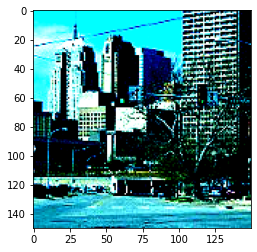

In [146]:
img, label = test_ds[1000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', ds.classes[label], ', Predicted:', predict_image(img, model))

In [147]:
cls_data = [[],[]]

for i in range(len(test_ds)):
    img, label = test_ds[i]
    prediction = predict_image(img, model)
    cls_data[0].append(ds.classes[label])
    cls_data[1].append(prediction)


labels = ['sea','forest','mountain','glacier','buildings','street']

    
from sklearn.metrics import classification_report

print(classification_report(cls_data[0], cls_data[1]))

              precision    recall  f1-score   support

   buildings       0.77      0.86      0.81       437
      forest       0.96      0.94      0.95       474
     glacier       0.76      0.78      0.77       553
    mountain       0.79      0.81      0.80       525
         sea       0.90      0.83      0.86       510
      street       0.87      0.81      0.84       501

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000

